In [1]:
# Helpers
from collections import Counter, defaultdict
import numpy as np
from itertools import chain
import pickle
import datetime

#DB
from django.db.models import Case, IntegerField, Value

# Plot
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
folder = "data/comp1_2019_2/"

### Creating train and test sets
We have Q-Matrix for the first 54 solutions that were validated by the professors. So, we can only use that students that replied to these problems in the dataset.

#### Descriptive statistics

In [3]:
# Filter used problems and solutions
chapters = list(range(3,11))

d = datetime.date(2020, 1, 1)
problems = Problem.objects.filter(chapter__id__in=chapters, retrieved_date__lte=d)
solutions = Solution.objects.filter(problem__in=problems, ignore=False).values_list('problem', flat=True)
problems = solutions.order_by('problem').values_list(
    'problem', flat=True).distinct('problem')
print("Total number of questions: %d" % problems.count())
print("Total number of solutions: %d" % solutions.count())

# print("%d problems with 1 solution" % Counter(Counter(solutions).values())[1])
# print("%d problems with 2 solutions" % Counter(Counter(solutions).values())[2])

/data2/miniconda3/envs/machineteaching/lib/python3.6/site-packages/django/db/models/fields/__init__.py:1365: RuntimeWarning: DateTimeField Problem.retrieved_date received a naive datetime (2020-01-01 00:00:00) while time zone support is active.
  RuntimeWarning)


Total number of questions: 65
Total number of solutions: 65


### Build Q-Matrix
Total number of weeks: 8 (missed the two first weeks)

Total number of problems: 65

In [4]:
weeks_idx = list(problems.values_list('problem__chapter', flat=True
                                     ).distinct().order_by('problem__chapter__pk'))
questions_idx = list(problems)
q_matrix = np.zeros((len(weeks_idx), len(questions_idx)))

q_matrix_flat = Solution.objects.filter(problem__in=problems, ignore=False
                                       ).values_list('problem__pk', 'problem__chapter__pk')

for question_id, chapter_id in q_matrix_flat:
    q_matrix[ weeks_idx.index(chapter_id), questions_idx.index(question_id)]

In [5]:
with open("%s/q_matrix.pkl" % folder, "wb") as pklfile:
    pickle.dump(q_matrix, pklfile)

### Create train and test sets

In [6]:
# Get all students
user_blacklist = UserProfile.objects.filter(professor__user__username='sem_professor')

attempts = UserLog.objects.exclude(outcome='S').filter(
    timestamp__lt=OuterRef('timestamp'), user__id=OuterRef('user__id')).annotate(
    attempt=Count('*')).values('attempt')

# Remove group by values
attempts.query.set_group_by()

# Get users
users = UserLog.objects.filter(problem__in=problems, timestamp__lte=d).exclude(outcome='S').exclude(
    user__userprofile__in=user_blacklist).annotate(
    attempt=Subquery(attempts, output_field=IntegerField())).annotate(
    score=Case(
        When(outcome='F', then=Value(0.1)),
        When(outcome='P', then=Value(1)),
        output_field=IntegerField())).values_list(
    "user__id", "problem_id", "attempt", "score"#"outcome", "timestamp"
).order_by("timestamp").filter(attempt=1).values_list('user_id', flat=True)

data = UserLog.objects.filter(problem__in=problems).exclude(outcome='S').annotate(
    attempt=Subquery(attempts, output_field=IntegerField())).annotate(
    score=Case(
        When(outcome='F', then=Value(0)),
        When(outcome='P', then=Value(1)),
        output_field=IntegerField())).values_list(
    "user__id", "problem_id", "attempt", "score", #"outcome", #"timestamp"
).order_by("timestamp").filter(user__in=users)

/data2/miniconda3/envs/machineteaching/lib/python3.6/site-packages/django/db/models/fields/__init__.py:1365: RuntimeWarning: DateTimeField UserLog.timestamp received a naive datetime (2020-01-01 00:00:00) while time zone support is active.
  RuntimeWarning)


In [13]:
user_list = list(users.values_list('user_id', flat=True))
user_list

[426,
 439,
 440,
 443,
 453,
 503,
 442,
 505,
 492,
 504,
 490,
 449,
 491,
 501,
 496,
 437,
 507,
 421,
 493,
 441,
 499,
 494,
 513,
 434,
 516,
 431,
 523,
 522,
 520,
 530,
 524,
 525,
 518,
 532,
 534,
 519,
 526,
 527,
 529,
 528,
 535,
 537,
 521,
 539,
 541,
 533,
 540,
 542,
 543,
 544,
 545,
 549,
 550,
 551,
 552,
 557,
 555,
 554,
 573,
 553,
 559,
 558,
 577,
 576,
 561,
 574,
 575,
 548,
 556,
 579,
 531,
 580,
 581,
 582,
 583,
 584,
 585,
 586,
 588,
 589,
 587,
 591,
 592,
 595,
 593,
 448,
 601,
 599,
 605,
 438,
 451,
 452,
 606,
 603,
 423,
 420,
 611,
 419,
 608,
 432,
 412,
 602,
 500,
 502,
 515,
 613,
 612,
 616,
 514,
 614,
 621,
 619,
 604,
 629,
 510,
 632,
 628,
 630,
 636,
 635,
 637,
 639,
 641,
 642,
 640,
 626,
 643,
 509,
 644,
 598,
 646,
 625,
 645,
 638,
 647,
 631,
 416,
 506,
 497,
 607,
 517,
 430,
 651,
 627,
 652,
 446,
 415,
 414,
 633,
 418,
 435,
 429,
 618,
 624,
 444,
 536,
 656,
 508,
 654,
 648,
 609,
 659,
 660,
 422,
 445,
 662,
 663

In [14]:
with open('%s/users.pkl' % folder, "wb") as pklfile:
    pickle.dump(user_list, pklfile)

Attempts statistics

In [7]:
%%time
attempts_total = data.count()
users_total = users.count()
success_attempts = data.filter(score=1)
fail_attempts = data.filter(score=0)

print("Total of %d attempts" % attempts_total)
print("Total of %d students" % users_total)
print("Average of attempt per student: %.2f" % (attempts_total/users_total))
print("Success attempts: %d (%.2f%%)" % (success_attempts.count(),100*success_attempts.count()/attempts_total))
print("Failed attempts: %d (%.2f%%)" % (fail_attempts.count(), 100*fail_attempts.count()/attempts_total))

Total of 27782 attempts
Total of 181 students
Average of attempt per student: 153.49
Success attempts: 6944 (24.99%)
Failed attempts: 20838 (75.01%)
CPU times: user 51.3 ms, sys: 7.64 ms, total: 58.9 ms
Wall time: 2min 44s


In [9]:
def print_stats(title, values):
    op = {
        "3. Min: %d": min,
        "4. Max: %d": max,
        "1. Avg: %.2f:": np.mean,
        "2. Median: %d": np.median
    }
    
    stats = title + "\n"
    results = []
    for key, value in op.items():
        results.append(key % value(list(values)))
        
    results.sort()
    stats += "\n".join(results) + "\n"
    return stats

Attempts x Question
1. Avg: 427.42:
2. Median: 350
3. Min: 91
4. Max: 1292

Attempts x Student
1. Avg: 153.49:
2. Median: 114
3. Min: 2
4. Max: 1002

Student x Question
1. Avg: 87.57:
2. Median: 87
3. Min: 42
4. Max: 145

Question x Student
1. Avg: 31.45:
2. Median: 31
3. Min: 1
4. Max: 65



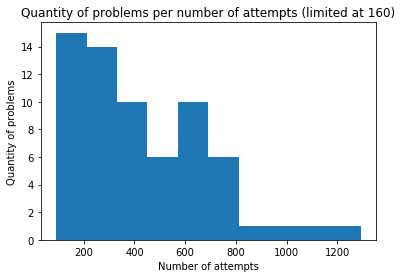

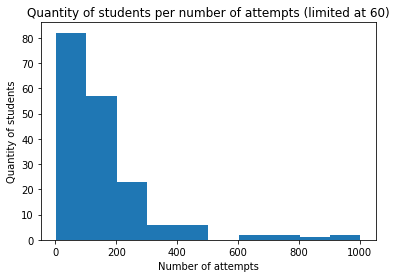

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

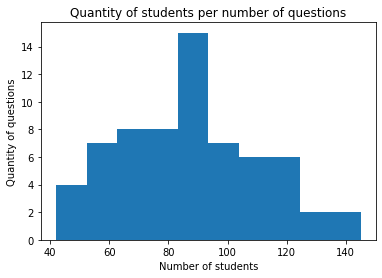

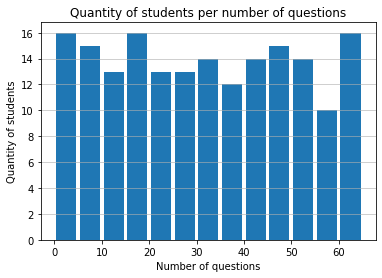

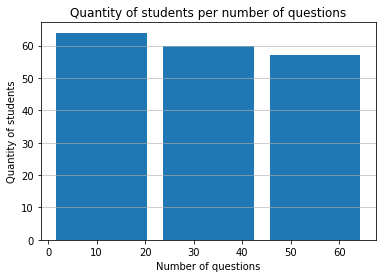

CPU times: user 1.56 s, sys: 29.7 ms, total: 1.59 s
Wall time: 14.4 s


(array([64., 60., 57.]), array([ 0, 22, 44, 66]), <a list of 3 Patch objects>)

In [10]:
%%time
attempts_per_question = defaultdict(int)
attempts_per_student = defaultdict(int)
questions_per_student = defaultdict(set)
students_per_question = defaultdict(set)
total_questions_per_student = defaultdict(int)
total_students_per_question = defaultdict(int)

for row in data:
    s_idx, q_idx, a_idx, outcome = row
    attempts_per_question[q_idx] += 1
    attempts_per_student[s_idx] += 1
    questions_per_student[s_idx].add(q_idx)
    students_per_question[q_idx].add(s_idx)
    total_questions_per_student[s_idx] = len(set(questions_per_student[s_idx]))
    total_students_per_question[q_idx] = len(set(students_per_question[q_idx]))

# Attempts x question
print(print_stats("Attempts x Question", attempts_per_question.values()))

# Attempts x student
print(print_stats("Attempts x Student", attempts_per_student.values()))

# Question x student
print(print_stats("Student x Question", total_students_per_question.values()))

# Student x question
print(print_stats("Question x Student", total_questions_per_student.values()))

# f, subs = plt.subplots(1, 2, figsize=(12,4))
fig = plt.figure(figsize=(6,4))
# bins_question = subs[0].hist(attempts_per_question.values(), bins=list(range(0,160, 20)))
# subs[0].set_title("Quantity of problems per number of attempts (limited at 160)")
# subs[0].set_xlabel("Number of attempts")
# subs[0].set_ylabel("Quantity of problems")
plt.hist(attempts_per_question.values())#, bins=list(range(0,160, 20)))
plt.title("Quantity of problems per number of attempts (limited at 160)")
plt.xlabel("Number of attempts")
plt.ylabel("Quantity of problems")
plt.savefig('edm2020/semester_attempts_problems.eps', format='eps')
plt.savefig('edm2020/semester_attempts_problems.png', format='png')
plt.show()

fig = plt.figure(figsize=(6,4))
plt.hist(attempts_per_student.values())#, bins=list(range(0,60,5)))
plt.title("Quantity of students per number of attempts (limited at 60)")
plt.xlabel("Number of attempts")
plt.ylabel("Quantity of students")
plt.savefig('edm2020/semester_attempts_students.eps', format='eps')
plt.savefig('edm2020/semester_attempts_students.png', format='png')
plt.show()

# bins_students = subs[1].hist(attempts_per_student.values(), bins=list(range(0,60,5)))
# subs[1].set_title("Quantity of students per number of attempts (limited at 60)")
# subs[1].set_xlabel("Number of attempts")
# subs[1].set_ylabel("Quantity of students")
# # subs[1][1].hist(attempts_per_student.values(), bins=list(range(60,400,5)))
# plt.tight_layout()

fig = plt.figure(figsize=(6,4))
bins = plt.hist(total_students_per_question.values())#, bins=list(range(0,50,1)))
plt.title("Quantity of students per number of questions")
plt.xlabel("Number of students")
plt.ylabel("Quantity of questions")
# plt.savefig('edm2020/attempts_students.eps', format='eps')
# plt.savefig('edm2020/attempts_students.png', format='png')

fig = plt.figure(figsize=(6,4))
bins = plt.hist(total_questions_per_student.values(),
                rwidth=0.85
               , bins=list(range(0,70,5))
               )
plt.title("Quantity of students per number of questions")
plt.xlabel("Number of questions")
plt.ylabel("Quantity of students")
plt.grid(axis='y', alpha=0.75)
plt.savefig('edm2020/semester_students_question.eps', format='eps')
plt.savefig('edm2020/semester_students_question.png', format='png')

fig = plt.figure(figsize=(6,4))
bins = plt.hist(total_questions_per_student.values(),
                rwidth=0.85
               , bins=list(range(0,70,22))
               )
plt.title("Quantity of students per number of questions")
plt.xlabel("Number of questions")
plt.ylabel("Quantity of students")
plt.grid(axis='y', alpha=0.75)
plt.savefig('edm2020/semester_students_question_thirds.eps', format='eps')
plt.savefig('edm2020/semester_students_question_thirds.png', format='png')

plt.show()
bins

In [13]:
with open('%s/questions_per_student.pkl' % folder, 'wb') as pklfile:
    pickle.dump(questions_per_student, pklfile)

Success attempts x Student
1. Avg: 38.79:
2. Median: 32
3. Min: 1
4. Max: 159

Failed attempts x Student
1. Avg: 115.77:
2. Median: 71
3. Min: 1
4. Max: 879

Success attempts x Question
1. Avg: 106.83:
2. Median: 106
3. Min: 55
4. Max: 219

Failed attempts x Question
1. Avg: 320.58:
2. Median: 262
3. Min: 24
4. Max: 1156



The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

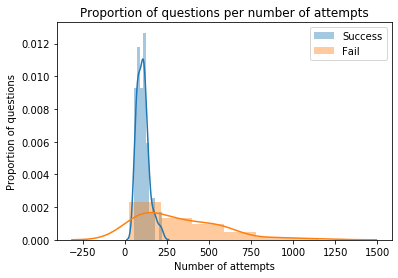

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


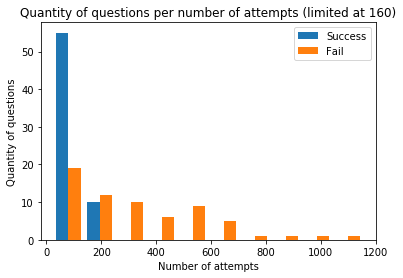

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

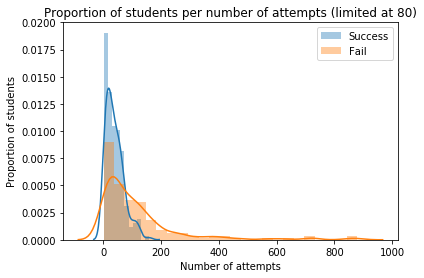

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


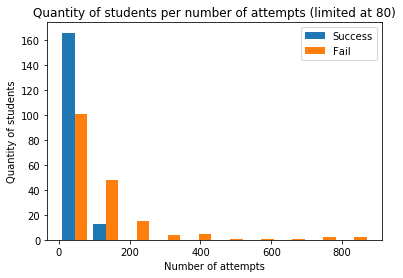

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


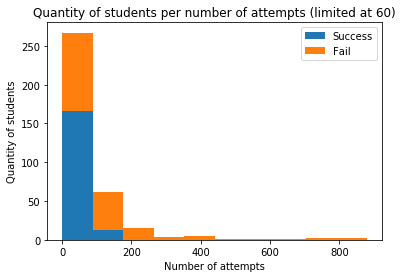

CPU times: user 2.33 s, sys: 67.5 ms, total: 2.4 s
Wall time: 1min 27s


In [11]:
%%time
success_per_student = defaultdict(int)
fail_per_student = defaultdict(int)
success_per_question = defaultdict(int)
fail_per_question = defaultdict(int)

for row in success_attempts:
    s_idx, q_idx, a_idx, outcome = row
    success_per_student[s_idx] += 1
    success_per_question[q_idx] += 1

    
for row in fail_attempts:
    s_idx, q_idx, a_idx, outcome = row
    fail_per_student[s_idx] += 1
    fail_per_question[q_idx] += 1
    
# Success attempt x Student
print(print_stats("Success attempts x Student", success_per_student.values()))

# Failed attempt x Student
print(print_stats("Failed attempts x Student", fail_per_student.values()))

# Success attempt x Question
print(print_stats("Success attempts x Question", success_per_question.values()))

# Fail attempt x Question
print(print_stats("Failed attempts x Question", fail_per_question.values()))

fig = plt.figure(figsize=(6,4))
# plt.hist([list(success_per_question.values()), list(fail_per_question.values())], 
#          bins=list(range(0,160, 20)), label=["Success", "Fail"], histtype='bar')
sns.distplot(list(success_per_question.values()), 
#              bins=list(range(0,160, 20)), 
             label="Success",
#              kde_kws={"bw": 8}
            )
sns.distplot(list(fail_per_question.values()), 
#              bins=list(range(0,160, 20)), 
             label="Fail")
plt.title("Proportion of questions per number of attempts")
plt.xlabel("Number of attempts")
plt.ylabel("Proportion of questions")
plt.legend()
# plt.xlim(-20,160)
plt.savefig('edm2020/semester_attempts_questions_sep_kde.eps', format='eps')
plt.savefig('edm2020/semester_attempts_questions_sep_kde.png', format='png')
plt.show()

fig = plt.figure(figsize=(6,4))
plt.hist([list(success_per_question.values()), list(fail_per_question.values())], 
#          bins=list(range(0,160, 20)), 
         label=["Success", "Fail"], histtype='bar')
plt.title("Quantity of questions per number of attempts (limited at 160)")
plt.xlabel("Number of attempts")
plt.ylabel("Quantity of questions")
plt.legend()
plt.savefig('edm2020/semester_attempts_questions_sep.eps', format='eps')
plt.savefig('edm2020/semester_attempts_questions_sep.png', format='png')
plt.show()

fig = plt.figure(figsize=(6,4))
sns.distplot(list(success_per_student.values()), 
#              bins=list(range(0,60,5)), 
             label="Success",
#              kde_kws={"bw": 2}
            )
sns.distplot(list(fail_per_student.values()), 
#              bins=list(range(0,60,5)), 
             label="Fail",
#              kde_kws={"bw": 6}
            )
# plt.xlim(-20,80)
plt.title("Proportion of students per number of attempts (limited at 80)")
plt.xlabel("Number of attempts")
plt.ylabel("Proportion of students")
plt.legend()
plt.savefig('edm2020/semester_attempts_students_sep_kde.eps', format='eps')
plt.savefig('edm2020/semester_attempts_students_sep_kde.png', format='png')
plt.show()

fig = plt.figure(figsize=(6,4))
plt.hist([list(success_per_student.values()), list(fail_per_student.values())], 
#          bins=list(range(0,80,5)), 
         label=["Success", "Fail"], histtype='bar')
plt.title("Quantity of students per number of attempts (limited at 80)")
plt.xlabel("Number of attempts")
plt.ylabel("Quantity of students")
plt.legend()
plt.savefig('edm2020/semester_attempts_students_sep.eps', format='eps')
plt.savefig('edm2020/semester_attempts_students_sep.png', format='png')
plt.show()


fig = plt.figure(figsize=(6,4))
plt.hist([list(success_per_student.values()), list(fail_per_student.values())], 
#          bins=list(range(0,60,5)), 
         label=["Success", "Fail"], histtype='barstacked')
plt.title("Quantity of students per number of attempts (limited at 60)")
plt.xlabel("Number of attempts")
plt.ylabel("Quantity of students")
plt.legend()
plt.savefig('edm2020/semester_attempts_students_sep_stacked.eps', format='eps')
plt.savefig('edm2020/semester_attempts_students_sep_stacked.png', format='png')
plt.show()

Delete student that do not meet minimum number of attempts

In [14]:
MIN_STUDENT_ATTEMPT = 3
MIN_QUESTION_ATTEMPT = 10

In [15]:
del_students = [item[0] for item in attempts_per_student.items() if item[1] < MIN_STUDENT_ATTEMPT]
del_questions = [item[0] for item in attempts_per_question.items() if item[1] < MIN_QUESTION_ATTEMPT]

Splitting in train and test

In [19]:
N_RUNS = 5
TRAIN_PROPORTION = 0.8
TRAIN_ATTEMPTS_TEST = 0.2

In [17]:
def get_user_idx(user_id):
    return users_idx.index(user_id)

def get_question_idx(question_id):
    return questions_idx.index(question_id)

def separate_users_train_and_test(users_idx):
    np.random.shuffle(users_idx)
    idx = int(np.ceil(TRAIN_PROPORTION*len(users)))
    train_users = users_idx[:idx]
    test_users = users_idx[idx:]
    return train_users, test_users

map_user_id = np.vectorize(get_user_idx)    
map_question_id = np.vectorize(get_question_idx)

Split in train and test

In [16]:
%%time
users_filtered = users.exclude(user_id__in=del_students)
users_idx = list(users_filtered)

for i in range(N_RUNS):
    train_users, test_users = separate_users_train_and_test(users_idx)
    
    # These users will be uniquely used for train
    train_set = list(data.filter(user_id__in=train_users))
    
    # Some users will be used in training up to a 20% of their attempts
    test_set = []
    # train_attempts = np.random.uniform(size=len(test_users))
    for idx, user in enumerate(test_users):
        user_attempts = data.filter(user_id=user)
        train_attempts = int(np.ceil(TRAIN_ATTEMPTS_TEST*user_attempts.count()))
        train_set.extend(list(user_attempts.filter(attempt__lte=train_attempts).order_by('attempt')))
        test_set.extend(list(user_attempts.filter(attempt__gt=train_attempts).order_by('attempt')))
        
    # Mapping users and questions to be in 0-len index
    train_set = np.asarray(train_set)
    test_set = np.asarray(test_set)
    
    train_set[:,0] = map_user_id(train_set[:,0])
    test_set[:,0] = map_user_id(test_set[:,0])
    
    train_set[:,1] = map_question_id(train_set[:,1])
    test_set[:,1] = map_question_id(test_set[:,1])
    
    dataset = {
        "train_set": train_set,
        "test_set": test_set,
        "concept_idx": concept_idx,
        "questions_idx": questions_idx,
        "users_idx": users_idx,
        "q_matrix": q_matrix,
    }
    
    # Save data
    with open("%s/run_%d.pkl" % (folder, i), "wb") as pklfile:
        pickle.dump(dataset, pklfile)

All data

In [24]:
users_filtered = users.exclude(user_id__in=del_students)
users_idx = list(users_filtered)

# These users will be uniquely used for train
train_set = list(data.filter(user_id__in=users_idx))
test_set = []

# Mapping users and questions to be in 0-len index
train_set = np.asarray(train_set)
test_set = np.asarray(test_set)

train_set[:,0] = map_user_id(train_set[:,0])
# test_set[:,0] = map_user_id(test_set[:,0])

train_set[:,1] = map_question_id(train_set[:,1])
# test_set[:,1] = map_question_id(test_set[:,1])

dataset = {
    "train_set": train_set,
    "test_set": test_set,
    "concept_idx": concept_idx,
    "questions_idx": questions_idx,
    "users_idx": users_idx,
    "q_matrix": q_matrix,
}

# Save data
with open("%s/all_data.pkl" % (folder), "wb") as pklfile:
    pickle.dump(dataset, pklfile)

In [52]:
import itertools

In [57]:
users = []
for i in range(5):
# Open data
    with open("%s/run_%d.pkl" % (folder, i), "rb") as pklfile:
        dataset = pickle.load(pklfile)
    users.append(dataset['users_idx'][158:])
    
for a, b in itertools.combinations(range(5), 2):
    print("same users in %d and %d" % (a,b))
    print(set(users[a]) & set(users[b]))

same users in 0 and 1
{217}
same users in 0 and 2
{222, 182, 71}
same users in 0 and 3
set()
same users in 0 and 4
{209, 107, 140}
same users in 1 and 2
{266, 183}
same users in 1 and 3
{268}
same users in 1 and 4
{281, 266}
same users in 2 and 3
{94, 108, 150, 92}
same users in 2 and 4
{266}
same users in 3 and 4
{54}
